In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [2]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        #we don't need to resize into 96*96 because we are doing that in below contrastive transform (self.resize_transform = transforms.resize((96,96)))
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        return image1, image2, image

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    #transforms.RandomGrayscale(p=0.2),
    #transforms.GaussianBlur(kernel_size=9),
])

# Create the dataset
image_dir = r"../../tiff_experiment_unsupervised_data/combined"

dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

def compute_mean_std(dataloader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for images, _ in dataloader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)  # reshape to (N, C, H*W)
        mean += images.mean(2).mean(0)  # calculate mean per channel
        std += images.std(2).std(0)  # calculate std per channel
        nb_samples += batch_samples
    
    mean /= nb_samples
    std /= nb_samples
    return mean, std


In [5]:
for i, (image1, image2, image) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    print(f"  image: {image.shape}")
    break

Batch 0:
  Image1: torch.Size([16, 3, 96, 96])
  Image2: torch.Size([16, 3, 96, 96])
  image: torch.Size([16, 3, 2054, 2456])


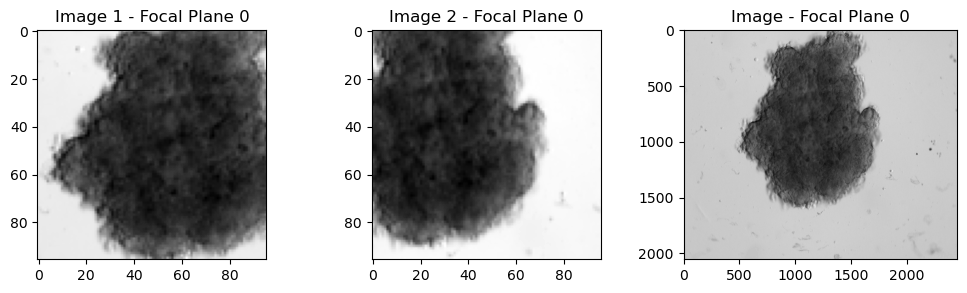

In [6]:
for i, (image1, image2, image) in enumerate(train_loader):
    # Select the first focal plane (layer) for visualization
    layer_to_visualize = 0  # Change this to 1 or 2 if you want other layers
    
    plt.figure(figsize=(10, 3))
    
    # Normalize the 16-bit image to range [0, 1] for visualization
    image1_normalized = image1[0, layer_to_visualize].float()
    image2_normalized = image2[0, layer_to_visualize].float()
    image_normalized = image[0, layer_to_visualize].float()
    
    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1_normalized, cmap='gray')
    plt.title(f'Image 1 - Focal Plane {layer_to_visualize}')
    
    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2_normalized, cmap='gray')
    plt.title(f'Image 2 - Focal Plane {layer_to_visualize}')
    
    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image_normalized, cmap='gray')
    plt.title(f'Image - Focal Plane {layer_to_visualize}')
    
    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


In [7]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [8]:
def plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    plt.figure(figsize=(16, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Top-1 accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.title('Training and Validation Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Plot Top-5 accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.title('Training and Validation Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Plot Mean Positive Position
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_mean_pos, 'bo-', label='Training Mean Positive Position')
    plt.plot(epochs, val_mean_pos, 'ro-', label='Validation Mean Positive Position')
    plt.title('Training and Validation Mean Positive Position')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Position')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = SimCLR(hidden_dim=hidden_dim, lr=lr, temperature=temperature, weight_decay=weight_decay).to(device)
    
    # Lists to store the metrics
    train_losses, val_losses = [], []
    train_top1_accs, val_top1_accs = [], []
    train_top5_accs, val_top5_accs = [], []
    train_mean_pos, val_mean_pos = [], []

    start_time = time.time()

    for epoch in range(max_epochs):
        epoch_start_time = time.time()

        # Train and validate the model
        train_loss, train_top1_acc, train_top5_acc, train_mean_pos_val = model.train_epoch(train_loader, device)
        val_loss, val_top1_acc, val_top5_acc, val_mean_pos_val = model.validate_epoch(val_loader, device)
        
        # Store the metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_top1_accs.append(train_top1_acc)
        val_top1_accs.append(val_top1_acc)
        train_top5_accs.append(train_top5_acc)
        val_top5_accs.append(val_top5_acc)
        train_mean_pos.append(train_mean_pos_val)
        val_mean_pos.append(val_mean_pos_val)
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Print metrics for the current epoch
        print(f"Epoch {epoch+1}/{max_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Top-1 Acc: {train_top1_acc:.2f}% | Top-5 Acc: {train_top5_acc:.2f}% | "
              f"Mean Pos: {train_mean_pos_val:.2f} | "
              f"Val Loss: {val_loss:.4f} | Top-1 Acc: {val_top1_acc:.2f}% | "
              f"Top-5 Acc: {val_top5_acc:.2f}% | Mean Pos: {val_mean_pos_val:.2f} | "
              f"Time Taken: {epoch_duration:.2f} seconds")

    end_time = time.time()
    total_duration = end_time - start_time
    print(f"Total Training Time: {total_duration:.2f} seconds")

    # Plot results
    plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos)

    return model

Using device: cuda


Epoch 1/1 | Train Loss: 3.0655 | Top-1 Acc: 0.10% | Top-5 Acc: 0.42% | Mean Pos: 9.13 | Val Loss: 2.6904 | Top-1 Acc: 0.17% | Top-5 Acc: 0.52% | Mean Pos: 6.27 | Time Taken: 29.17 seconds
Total Training Time: 29.17 seconds


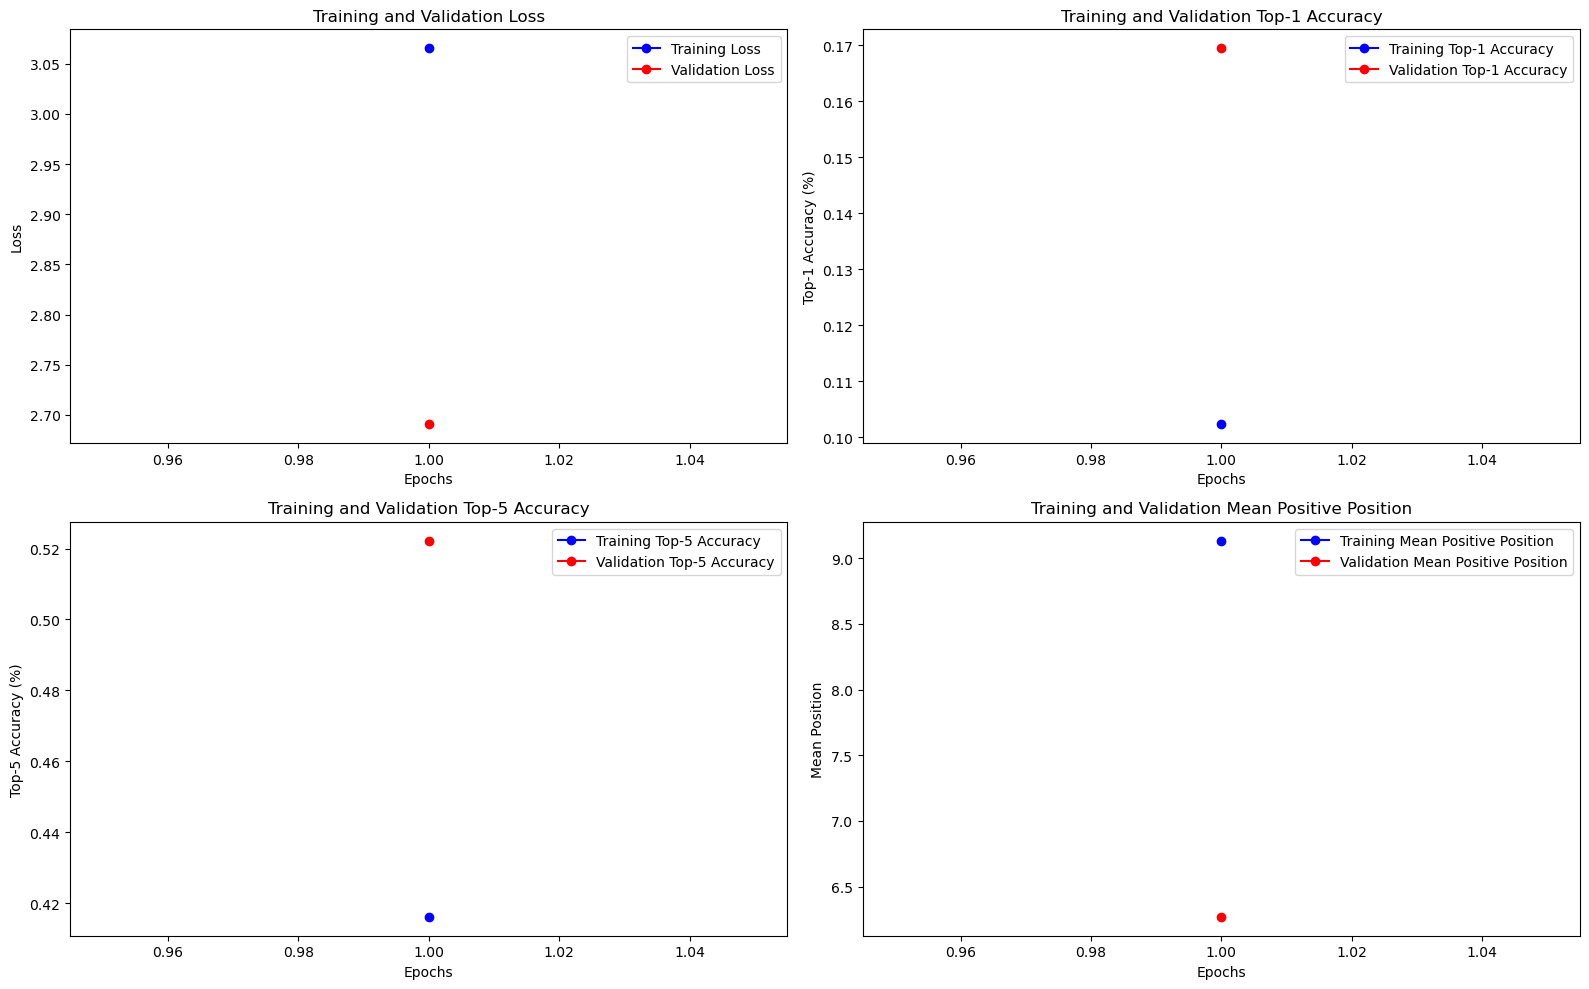

In [10]:
# Run the training script
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=1)

In [3]:
full_model_path =  r'C:\Users\k54739\saved_model\simclr_model.pth' 

In [4]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [5]:
simclr_model = torch.load(full_model_path)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_22524\181344158.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model = torch.load(full_model_path)


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [6]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Logistic

In [7]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    #classes = ['untreated', 'single_dose', 'drug_screened']
    classes = ['untreated', 'single_dose']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"../../Data_supervised"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [8]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1])


In [9]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [10]:
# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)

 33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 67%|██████▋   | 2/3 [00:01<00:00,  1.06it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Features shape after concatenation: torch.Size([48, 512])
Labels shape after concatenation: torch.Size([48])


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

Batch features shape: torch.Size([12, 512])
Batch labels shape: torch.Size([12])
Features shape after concatenation: torch.Size([12, 512])
Labels shape after concatenation: torch.Size([12])


In [11]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [12]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [13]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [14]:
# Main training loop
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0) #num_workers =os.cpu_count()
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_test_acc = 0.0
    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)
        
        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict()

    # Load best model state
    model.load_state_dict(best_model_state)

    # Plot results
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(max_epochs), train_losses, label='Train Loss')
    plt.plot(range(max_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(max_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(max_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, {"train_acc": train_acc, "test_acc": test_acc}

Epoch 1/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 199.87it/s]


Training loss: 0.4847, Training accuracy: 0.9167
Test loss: 0.1484, Test accuracy: 1.0000
Epoch 2/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 181.73it/s]


Training loss: 0.1031, Training accuracy: 1.0000
Test loss: 0.0379, Test accuracy: 1.0000
Epoch 3/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.04it/s]


Training loss: 0.0455, Training accuracy: 1.0000
Test loss: 0.0354, Test accuracy: 1.0000
Epoch 4/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 152.14it/s]


Training loss: 0.0441, Training accuracy: 1.0000
Test loss: 0.0352, Test accuracy: 1.0000
Epoch 5/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 141.87it/s]


Training loss: 0.0439, Training accuracy: 1.0000
Test loss: 0.0350, Test accuracy: 1.0000
Epoch 6/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 217.75it/s]


Training loss: 0.0436, Training accuracy: 1.0000
Test loss: 0.0348, Test accuracy: 1.0000
Epoch 7/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 285.71it/s]


Training loss: 0.0434, Training accuracy: 1.0000
Test loss: 0.0346, Test accuracy: 1.0000
Epoch 8/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 179.02it/s]


Training loss: 0.0431, Training accuracy: 1.0000
Test loss: 0.0344, Test accuracy: 1.0000
Epoch 9/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 399.99it/s]


Training loss: 0.0429, Training accuracy: 1.0000
Test loss: 0.0342, Test accuracy: 1.0000
Epoch 10/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 399.51it/s]


Training loss: 0.0426, Training accuracy: 1.0000
Test loss: 0.0341, Test accuracy: 1.0000
Epoch 11/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 490.30it/s]


Training loss: 0.0424, Training accuracy: 1.0000
Test loss: 0.0339, Test accuracy: 1.0000
Epoch 12/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 499.17it/s]


Training loss: 0.0422, Training accuracy: 1.0000
Test loss: 0.0337, Test accuracy: 1.0000
Epoch 13/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 499.23it/s]


Training loss: 0.0419, Training accuracy: 1.0000
Test loss: 0.0335, Test accuracy: 1.0000
Epoch 14/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 324.25it/s]


Training loss: 0.0416, Training accuracy: 1.0000
Test loss: 0.0333, Test accuracy: 1.0000
Epoch 15/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 483.05it/s]


Training loss: 0.0414, Training accuracy: 1.0000
Test loss: 0.0331, Test accuracy: 1.0000
Epoch 16/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 470.29it/s]


Training loss: 0.0411, Training accuracy: 1.0000
Test loss: 0.0329, Test accuracy: 1.0000
Epoch 17/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 181.82it/s]


Training loss: 0.0408, Training accuracy: 1.0000
Test loss: 0.0327, Test accuracy: 1.0000
Epoch 18/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 330.42it/s]


Training loss: 0.0406, Training accuracy: 1.0000
Test loss: 0.0325, Test accuracy: 1.0000
Epoch 19/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 499.35it/s]


Training loss: 0.0403, Training accuracy: 1.0000
Test loss: 0.0322, Test accuracy: 1.0000
Epoch 20/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 199.87it/s]


Training loss: 0.0400, Training accuracy: 1.0000
Test loss: 0.0320, Test accuracy: 1.0000


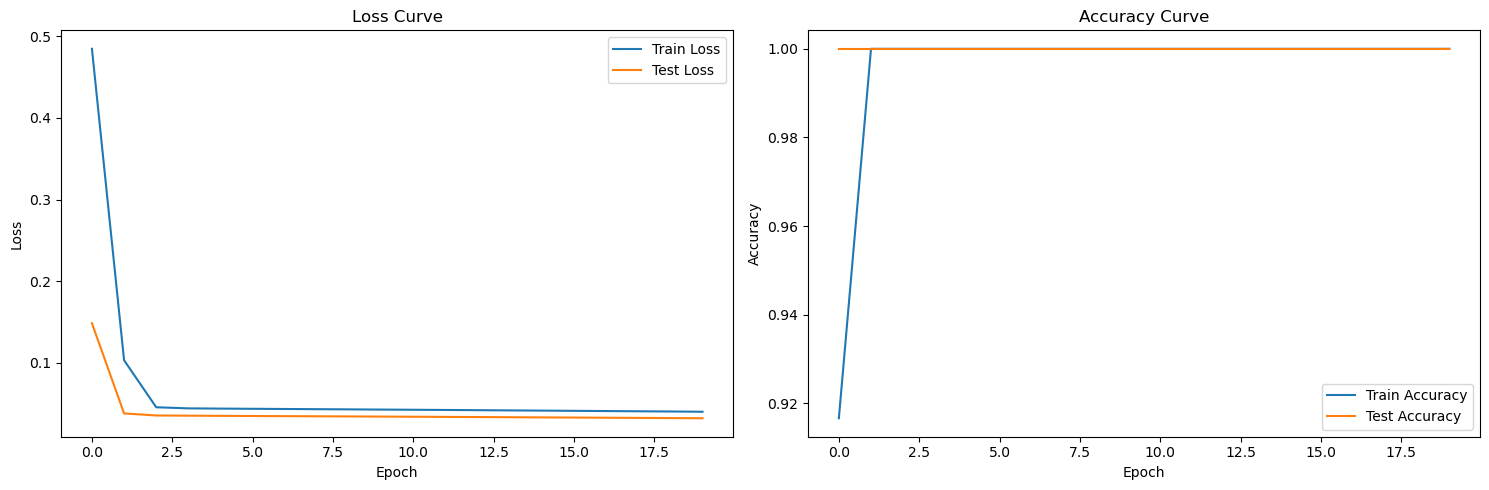

In [15]:
# Train the logistic regression model
logreg_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=3,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=20
)

#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


In [20]:
train_feats_simclr.tensors[0].shape[1]

512

After projection head

In [16]:
@torch.no_grad()
def feature_after_projection(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    #network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [18]:
# Extract features for train and test datasets
train_feats_after = feature_after_projection(simclr_model, train_loader_labeled)
test_feats_after = feature_after_projection(simclr_model, test_loader_labeled)

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.19it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 67%|██████▋   | 2/3 [00:01<00:00,  1.23it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])
Features shape after concatenation: torch.Size([48, 20])
Labels shape after concatenation: torch.Size([48])


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

Batch features shape: torch.Size([12, 20])
Batch labels shape: torch.Size([12])
Features shape after concatenation: torch.Size([12, 20])
Labels shape after concatenation: torch.Size([12])


Epoch 1/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 151.24it/s]


Training loss: 0.5927, Training accuracy: 0.7083
Test loss: 0.3875, Test accuracy: 0.9167
Epoch 2/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 133.33it/s]


Training loss: 0.4836, Training accuracy: 0.7917
Test loss: 0.3003, Test accuracy: 0.9167
Epoch 3/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 92.68it/s]


Training loss: 0.4277, Training accuracy: 0.8125
Test loss: 0.2950, Test accuracy: 0.9167
Epoch 4/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 218.58it/s]


Training loss: 0.4241, Training accuracy: 0.8333
Test loss: 0.2943, Test accuracy: 0.9167
Epoch 5/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 245.96it/s]


Training loss: 0.4233, Training accuracy: 0.8333
Test loss: 0.2936, Test accuracy: 0.9167
Epoch 6/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 200.02it/s]


Training loss: 0.4225, Training accuracy: 0.8333
Test loss: 0.2929, Test accuracy: 0.9167
Epoch 7/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 202.50it/s]


Training loss: 0.4218, Training accuracy: 0.8333
Test loss: 0.2922, Test accuracy: 0.9167
Epoch 8/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 399.95it/s]


Training loss: 0.4209, Training accuracy: 0.8333
Test loss: 0.2915, Test accuracy: 0.9167
Epoch 9/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 399.97it/s]


Training loss: 0.4202, Training accuracy: 0.8333
Test loss: 0.2908, Test accuracy: 0.9167
Epoch 10/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 333.40it/s]


Training loss: 0.4193, Training accuracy: 0.8333
Test loss: 0.2901, Test accuracy: 0.9167
Epoch 11/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 333.36it/s]


Training loss: 0.4186, Training accuracy: 0.8333
Test loss: 0.2894, Test accuracy: 0.9167
Epoch 12/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 500.04it/s]


Training loss: 0.4178, Training accuracy: 0.8333
Test loss: 0.2887, Test accuracy: 0.9167
Epoch 13/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 180.40it/s]


Training loss: 0.4170, Training accuracy: 0.8333
Test loss: 0.2880, Test accuracy: 0.9167
Epoch 14/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 400.11it/s]


Training loss: 0.4162, Training accuracy: 0.8333
Test loss: 0.2873, Test accuracy: 0.9167
Epoch 15/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 165.05it/s]


Training loss: 0.4154, Training accuracy: 0.8333
Test loss: 0.2867, Test accuracy: 0.9167
Epoch 16/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 324.60it/s]


Training loss: 0.4147, Training accuracy: 0.8333
Test loss: 0.2860, Test accuracy: 0.9167
Epoch 17/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 493.77it/s]


Training loss: 0.4139, Training accuracy: 0.8333
Test loss: 0.2853, Test accuracy: 0.9167
Epoch 18/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 312.18it/s]


Training loss: 0.4131, Training accuracy: 0.8333
Test loss: 0.2846, Test accuracy: 0.9167
Epoch 19/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 488.45it/s]


Training loss: 0.4123, Training accuracy: 0.8333
Test loss: 0.2839, Test accuracy: 0.9167
Epoch 20/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 500.10it/s]


Training loss: 0.4115, Training accuracy: 0.8333
Test loss: 0.2832, Test accuracy: 0.9167


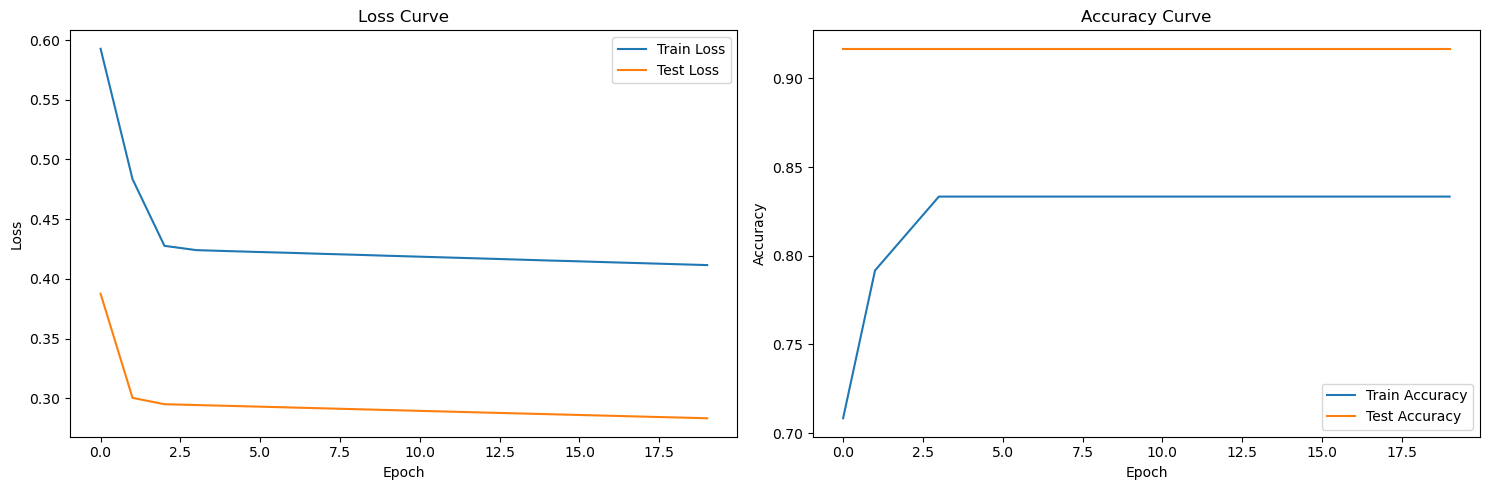

In [20]:
# Train the logistic regression model
logreg_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_after,
    test_feats_data=test_feats_after,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=3,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=20
)

#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


as expected after projection not good for linear classification.